## Initialization

### Import packages

In [14]:
%load_ext autoreload
%autoreload 2

In [15]:
import time
import torch
import random
import numpy as np
import pickle
import torch.nn.functional as F
from copy import deepcopy
from multiprocessing import Pool
from tqdm.notebook import tqdm

#from ENV import KYenv
from envs import KYenv as Env
from DRQN_controller import DRQN_Agent
from DRQN_learner import QLearner
from DRQN_agent import decode_act,get_decay

import matplotlib.pyplot as plt

### Initiliaze environments

In [16]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [17]:
envs = []


for s in tqdm(range(100)):
    set_seed(s)
#     t_aps = torch.rand(k)
    t_ues = torch.rand(10, 2) * torch.Tensor([40, 40])
    env = Env(boarder=100,
          apNum=4,ueNum=24,random_seed=s
          )
    envs.append(env)

  0%|          | 0/100 [00:00<?, ?it/s]

/sfs/qumulo/qhome/ky9tc/workarea/Dino-rl/envs/env.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  struct_ob.append(torch.tensor(self.ap_obv(i,self.top_K), dtype=torch.float32).view(-1))


In [7]:
envs[0].struct_obv().shape[0]

24

### Initialize models

In [18]:
inter_file_name = 'AP4UE10Act5_Individual_AVG.pkl'
# enable cuda in training
cuda_flag = True

# initialize learner
controller = DRQN_Agent(input_shape=24, n_actions=256) #n_actions = 6 * 5, input_shape = 11
controller.save('models/' + inter_file_name)
controller.cuda()
learner = QLearner(controller,device="cuda",batch_size=32,num_feats=64, est_type = "discounted")
if cuda_flag:
    learner.cuda()

# initialize test learner
test_controller = DRQN_Agent(input_shape=24, n_actions=256) #n_actions = 6 * 5, input_shape = 11
test_controller.load('models/' + inter_file_name)
test_controller.cuda()
# test_controller.init_hidden(batch_size=1)


reward = 0

In [19]:
inter_file_name = 'AP4UE10Act5_Individual.pkl'
# enable cuda in training
cuda_flag = True

# initialize learner
avg_controller = DRQN_Agent(input_shape=24, n_actions=256) #n_actions = 6 * 5, input_shape = 11
avg_controller.save('models/' + inter_file_name)
avg_controller.cuda()
avg_learner = QLearner(avg_controller,device="cuda",batch_size=32,num_feats=64, est_type = "average")
if cuda_flag:
    avg_learner.cuda()

# initialize test learner
test_controller = DRQN_Agent(input_shape=24, n_actions=256) #n_actions = 6 * 5, input_shape = 11
test_controller.load('models/' + inter_file_name)
test_controller.cuda()
# test_controller.init_hidden(batch_size=1)


reward = 0

### Training

In [ ]:
import pdb
# Defining hyperparams
niterations = 500
max_inner_iter = 1000
max_test_iter = 1000
outerstepsize = 1
# random_seeds = [0,5,3,6,9,14,16,25,22,29]
# random_seeds = [35, 40, 45]
random_seeds = [1,2,3,4,5]
k = 0
epsilon = 0.9
results_dict = {"loss": None,
               "reward": None}
# pbar = tqdm(range(niterations))
# best = 0
gamma = 0.98
# set_seed(15)
r_history, loss_history = [], []
for k in random_seeds:
    inter_file_name = 'AP4UE10Act5_Individual_dist.pkl'
# enable cuda in training
    cuda_flag = True

    # initialize learner
    controller = DRQN_Agent(input_shape=24, n_actions=256) #n_actions = 6 * 5, input_shape = 11
    controller.save('models/' + inter_file_name)
    controller.cuda()
    learner = QLearner(controller,device="cuda",batch_size=32,num_feats=64, est_type = "discounted")
    if cuda_flag:
        learner.cuda()

    # initialize test learner
    test_controller = DRQN_Agent(input_shape=24, n_actions=256) #n_actions = 6 * 5, input_shape = 11
    test_controller.load('models/' + inter_file_name)
    test_controller.cuda()
#     test_controller.init_hidden(batch_size=1)
    lr = 1e-2
    learner.set_sgd(lr)
    pbar = tqdm(range(niterations))
    env = envs[k]
    best = 0
    r_history, loss_history = [], []
    for iteration in pbar:
        env.reset()
        inner_step = 0
        if (iteration + 1) % 100 == 0:
            lr = lr/2
            lr = max(lr, 1e-4)
            learner.set_sgd(lr)
        losses = []
    
        for inner_iter in range(max_inner_iter):
            total_step = max_inner_iter * iteration + inner_iter
#         inner_step += 1
#             obs = [5
# #         breakpoint()
#             for j in range(env.n_enbs):
#                 obs.append(env.get_agent_obs(j))
#             obs = torch.stack(obs, dim=0)
#             obs = torch.flatten(obs)
            obs = env.struct_obv()
#         breakpoint()
            cur_obs = obs.reshape(1,24).cuda()
#             controller.init_hidden(1)
            action,q = controller.get_action(cur_obs, 0.5 * (1-iteration/niterations))
            if random.random() < epsilon:
                action = np.random.randint(255)
#             pdb.set_trace()
            act = decode_act(action,4,4)
            s_t1,r,_ = env.step(act)
            s_t1 = torch.flatten(s_t1)
#             controller.init_hidden(512)
            loss, grad = learner.train(obs.numpy(), action,
                                   r.item(), s_t1.numpy(), total_step)
            if loss is not None:
                losses.append(loss.item())
        
        learner._update_targets()
    # Save the results
        if losses != []:
            loss_history.append(np.mean(losses))
    # save and update the test controller
        controller.save('models/' + inter_file_name)
        test_controller.load('models/' + inter_file_name)
        env.reset()
        reward = 0
        epsilon -= 1/(niterations + 1)
        for test_iter in range(max_test_iter):
#             obs = []
#             for j in range(env.n_enbs):
#                 obs.append(env.get_agent_obs(j))
# #         breakpoint()
#             obs = torch.stack(obs, dim=0)
#             obs = torch.flatten(obs)
            obs = env.struct_obv()
            action,_ = test_controller.get_action(
                torch.reshape(obs,(1,24)).cuda(), 0.0)
#             action = 0
            act = decode_act(action,4,4)
            s_t1,r,_ = env.step(act)
            reward += r
        r_history.append(reward.item()/max_test_iter)
        pbar.set_description(f"Env:{k}|Iteration:{iteration}|loss:{np.mean(losses):.2f}|reward:{np.mean(r_history):.2f}|action:{act}")
        print(f"Env:{k}|Iteration:{iteration}|loss:{np.mean(losses):.2f}|reward:{reward.item()/max_test_iter:.2f}|action:{act}|rscore:{env.get_Rsum()/24 + env.get_R5per()*3}")
        if r.item() > best and iteration > 10:
            best = r.item()
            print(f"Current best {best:.2f} at iteration {iteration}! Saving.... ")
            test_controller.save(f"./models/drqn_best_centralized_env{k}.pkl")
        if (iteration + 1) % 50 == 0:
            plt.plot(r_history)
            plt.show()

            plt.plot(loss_history)
            plt.show()
            results_dict["loss"] = loss_history
            results_dict["reward"] = r_history
            with open(f"./results/env_{k}_centralized_results_{niterations}_dist.pkl", "wb") as file:
                pickle.dump(results_dict, file)
        

  0%|          | 0/500 [00:00<?, ?it/s]

Env:1|Iteration:0|loss:549.65|reward:19.12|action:tensor([0, 1, 2, 2])|rscore:0.5814136118457676
Env:1|Iteration:1|loss:457.22|reward:18.94|action:tensor([1, 3, 3, 2])|rscore:0.6623617476039179
Env:1|Iteration:2|loss:1054.12|reward:19.22|action:tensor([0, 3, 0, 3])|rscore:0.48671604611034003
Env:1|Iteration:3|loss:852.79|reward:19.78|action:tensor([3, 3, 1, 0])|rscore:0.7283764478810948
Env:1|Iteration:4|loss:816.87|reward:18.10|action:tensor([3, 3, 1, 0])|rscore:0.4808283631515736
Env:1|Iteration:5|loss:526.24|reward:17.64|action:tensor([3, 3, 1, 0])|rscore:0.2741628267998027
Env:1|Iteration:6|loss:580.02|reward:18.43|action:tensor([3, 1, 2, 3])|rscore:0.5847921481926164
Env:1|Iteration:7|loss:3297.18|reward:16.72|action:tensor([3, 0, 1, 1])|rscore:0.44050354568352446
Env:1|Iteration:8|loss:1072.92|reward:19.53|action:tensor([0, 3, 2, 2])|rscore:0.5457022400560716
Env:1|Iteration:9|loss:376.99|reward:19.20|action:tensor([1, 0, 1, 2])|rscore:0.5992353549889291
Env:1|Iteration:10|loss:4

  0%|          | 0/1000 [00:00<?, ?it/s]

Env:1|Iteration:0|loss:519.67|reward:19.69|action:tensor([0, 1, 3, 0])|rscore:0.6308130053511312
Env:1|Iteration:1|loss:641.70|reward:19.44|action:tensor([2, 1, 2, 2])|rscore:0.5774749178925201
Env:1|Iteration:2|loss:275.03|reward:18.38|action:tensor([2, 0, 1, 2])|rscore:0.5141262625805293
Env:1|Iteration:3|loss:540.88|reward:19.61|action:tensor([0, 3, 1, 2])|rscore:0.7105659172723261
Env:1|Iteration:4|loss:395.88|reward:19.29|action:tensor([2, 2, 3, 0])|rscore:0.5297109965087177
Env:1|Iteration:5|loss:586.87|reward:17.64|action:tensor([3, 1, 0, 1])|rscore:0.47138818156280693
Env:1|Iteration:6|loss:1025.41|reward:20.25|action:tensor([2, 0, 0, 3])|rscore:0.705352667670718
Env:1|Iteration:7|loss:607.12|reward:18.59|action:tensor([3, 1, 0, 1])|rscore:0.5325977292470647
Env:1|Iteration:8|loss:952.81|reward:19.14|action:tensor([2, 0, 0, 3])|rscore:0.6063866128019302
Env:1|Iteration:9|loss:162.65|reward:18.64|action:tensor([1, 3, 3, 3])|rscore:0.5015033163907633
Env:1|Iteration:10|loss:216.4

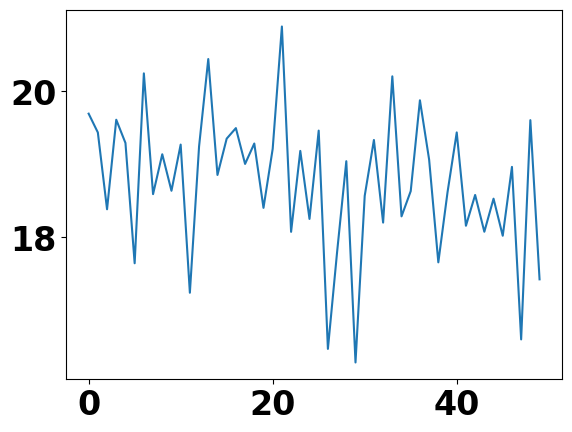

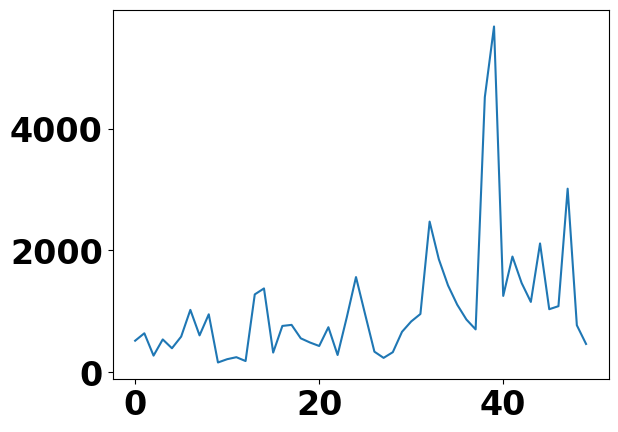

Env:1|Iteration:50|loss:1536.73|reward:19.47|action:tensor([2, 1, 2, 3])|rscore:0.7036786274665511
Env:1|Iteration:51|loss:2268.80|reward:20.33|action:tensor([2, 0, 1, 1])|rscore:0.723249821648287
Env:1|Iteration:52|loss:382.19|reward:18.56|action:tensor([0, 1, 0, 1])|rscore:0.617401183338505
Env:1|Iteration:53|loss:678.26|reward:20.15|action:tensor([2, 0, 1, 1])|rscore:0.5732861411151137
Env:1|Iteration:54|loss:1264.58|reward:16.39|action:tensor([3, 3, 1, 2])|rscore:0.2846724837957762
Env:1|Iteration:55|loss:1354.33|reward:20.49|action:tensor([3, 2, 3, 3])|rscore:0.7749745653754735
Env:1|Iteration:56|loss:1512.69|reward:19.52|action:tensor([2, 2, 0, 3])|rscore:0.485506272606434
Env:1|Iteration:57|loss:2777.06|reward:19.83|action:tensor([0, 3, 2, 2])|rscore:0.607674960477225
Env:1|Iteration:58|loss:3476.86|reward:20.25|action:tensor([2, 2, 0, 3])|rscore:0.7386874232551284
Env:1|Iteration:59|loss:453.67|reward:18.46|action:tensor([2, 2, 0, 3])|rscore:0.6373468414333425
Env:1|Iteration:6

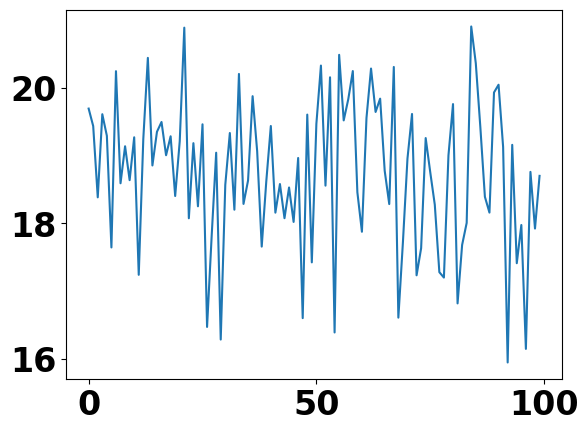

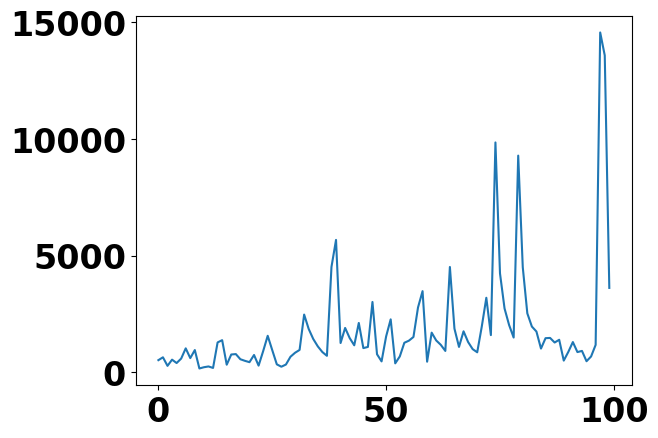

Env:1|Iteration:100|loss:5436.15|reward:17.79|action:tensor([2, 2, 0, 3])|rscore:0.28475047003032855
Env:1|Iteration:101|loss:10284.04|reward:19.88|action:tensor([2, 2, 0, 3])|rscore:0.6714075526406618
Env:1|Iteration:102|loss:3800.18|reward:18.39|action:tensor([2, 2, 0, 3])|rscore:0.5117702986894191
Env:1|Iteration:103|loss:3202.75|reward:19.98|action:tensor([0, 2, 1, 1])|rscore:0.6696184408226034
Env:1|Iteration:104|loss:2558.29|reward:18.84|action:tensor([2, 2, 0, 3])|rscore:0.5463106692363373
Env:1|Iteration:105|loss:3572.18|reward:19.82|action:tensor([2, 2, 0, 3])|rscore:0.5925483740398365
Env:1|Iteration:106|loss:2630.54|reward:19.44|action:tensor([3, 2, 3, 3])|rscore:0.5611424722833211
Env:1|Iteration:107|loss:2967.15|reward:17.51|action:tensor([3, 2, 1, 1])|rscore:0.28679527249365067
Env:1|Iteration:108|loss:1986.31|reward:19.94|action:tensor([0, 2, 1, 1])|rscore:0.669906848247441
Env:1|Iteration:109|loss:4641.94|reward:19.37|action:tensor([2, 0, 2, 0])|rscore:0.535284165828231

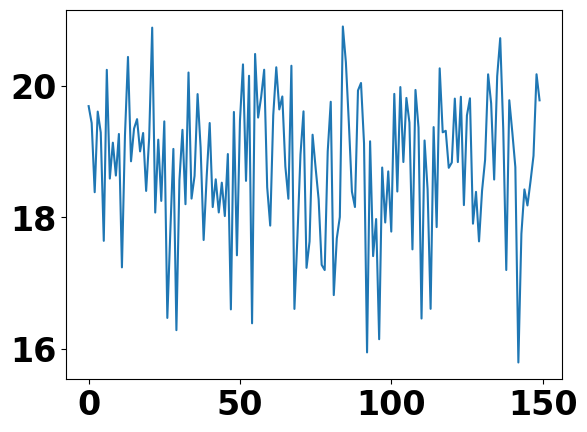

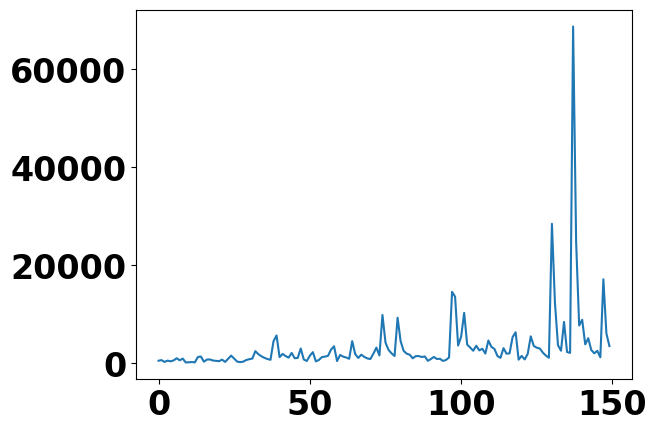

Env:1|Iteration:150|loss:2352.98|reward:18.34|action:tensor([2, 3, 0, 2])|rscore:0.5855111002555808
Env:1|Iteration:151|loss:7887.68|reward:19.76|action:tensor([1, 1, 0, 0])|rscore:0.5344858335942292
Env:1|Iteration:152|loss:16300.33|reward:18.44|action:tensor([0, 1, 1, 2])|rscore:0.5574743666792195
Env:1|Iteration:153|loss:6238.60|reward:18.46|action:tensor([3, 2, 0, 2])|rscore:0.5561943097528839
Env:1|Iteration:154|loss:3998.55|reward:18.00|action:tensor([3, 2, 0, 2])|rscore:0.4723788157003448
Env:1|Iteration:155|loss:5188.12|reward:18.10|action:tensor([3, 2, 0, 2])|rscore:0.5338762271200741
Env:1|Iteration:156|loss:3199.18|reward:19.91|action:tensor([2, 0, 0, 0])|rscore:0.5823955751080412
Env:1|Iteration:157|loss:1489.79|reward:17.99|action:tensor([3, 3, 0, 1])|rscore:0.5241797600766978
Env:1|Iteration:158|loss:7177.15|reward:19.28|action:tensor([3, 1, 2, 0])|rscore:0.6087922882466026
Env:1|Iteration:159|loss:5767.48|reward:20.04|action:tensor([0, 3, 1, 2])|rscore:0.579854791632962


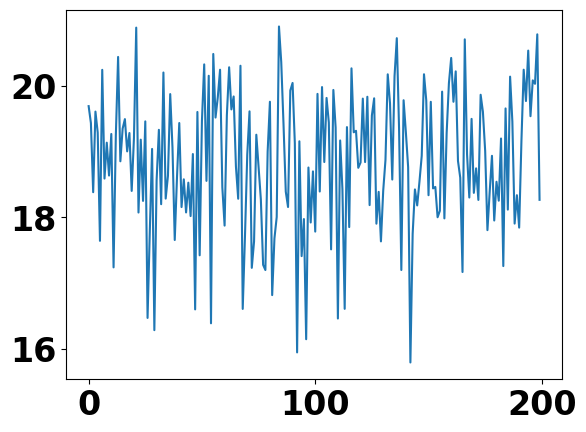

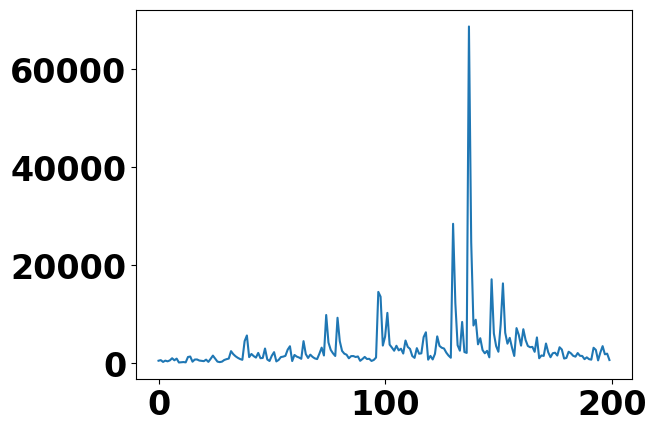

Env:1|Iteration:200|loss:1657.20|reward:16.34|action:tensor([0, 3, 0, 2])|rscore:0.2519758395948339
Env:1|Iteration:201|loss:1140.22|reward:20.53|action:tensor([0, 2, 1, 2])|rscore:0.7174806978306139
Env:1|Iteration:202|loss:1361.57|reward:19.92|action:tensor([0, 2, 1, 2])|rscore:0.5637710301314669
Env:1|Iteration:203|loss:1260.32|reward:20.55|action:tensor([0, 2, 1, 2])|rscore:0.6641244031943869
Env:1|Iteration:204|loss:1414.24|reward:18.96|action:tensor([2, 0, 0, 0])|rscore:0.5842728722807188
Env:1|Iteration:205|loss:910.08|reward:20.49|action:tensor([2, 0, 0, 0])|rscore:0.609733974648776
Env:1|Iteration:206|loss:929.21|reward:19.58|action:tensor([2, 0, 0, 0])|rscore:0.5744021486499318
Env:1|Iteration:207|loss:625.52|reward:19.07|action:tensor([2, 0, 0, 0])|rscore:0.6107321227880254
Env:1|Iteration:208|loss:778.81|reward:19.48|action:tensor([0, 2, 1, 2])|rscore:0.559639962803753
Env:1|Iteration:209|loss:514.56|reward:19.54|action:tensor([0, 2, 1, 2])|rscore:0.562440233412715
Env:1|It

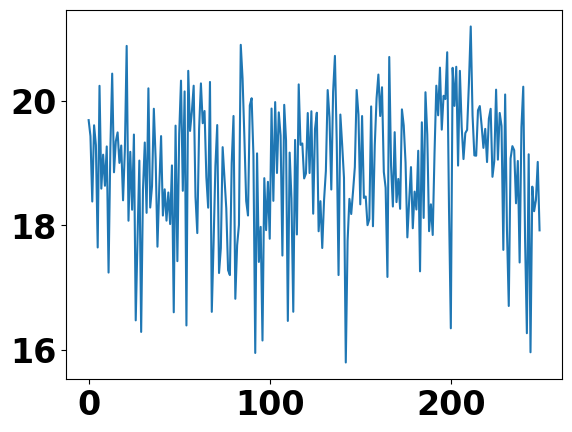

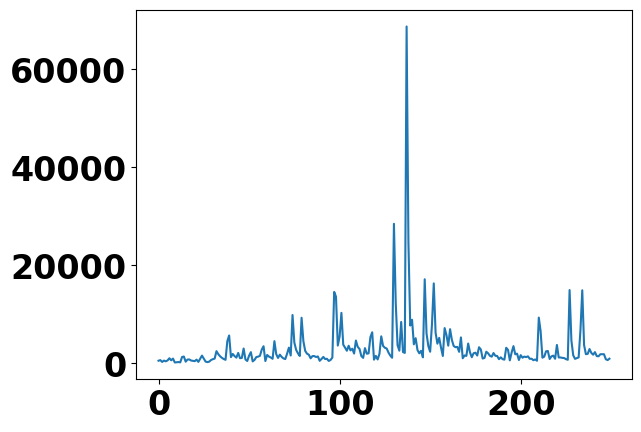

Env:1|Iteration:250|loss:949.44|reward:19.57|action:tensor([0, 2, 1, 2])|rscore:0.5164538231203661
Env:1|Iteration:251|loss:2366.12|reward:17.49|action:tensor([0, 0, 1, 2])|rscore:0.4278722917189939
Env:1|Iteration:252|loss:8198.74|reward:18.23|action:tensor([0, 2, 1, 2])|rscore:0.4868523778928367
Env:1|Iteration:253|loss:1848.95|reward:20.41|action:tensor([0, 2, 1, 2])|rscore:0.7268262690868607
Env:1|Iteration:254|loss:3222.65|reward:20.12|action:tensor([0, 2, 1, 2])|rscore:0.5753170271135625
Env:1|Iteration:255|loss:2981.68|reward:19.82|action:tensor([0, 2, 1, 2])|rscore:0.5626426925067265
Env:1|Iteration:256|loss:3702.10|reward:20.49|action:tensor([3, 2, 0, 0])|rscore:0.678461975416655
Env:1|Iteration:257|loss:2122.99|reward:18.71|action:tensor([3, 2, 0, 0])|rscore:0.5285588867614995
Env:1|Iteration:258|loss:1987.13|reward:18.31|action:tensor([2, 0, 0, 0])|rscore:0.44218427493928636
Env:1|Iteration:259|loss:2216.91|reward:19.08|action:tensor([2, 0, 0, 0])|rscore:0.5811822927802275
E

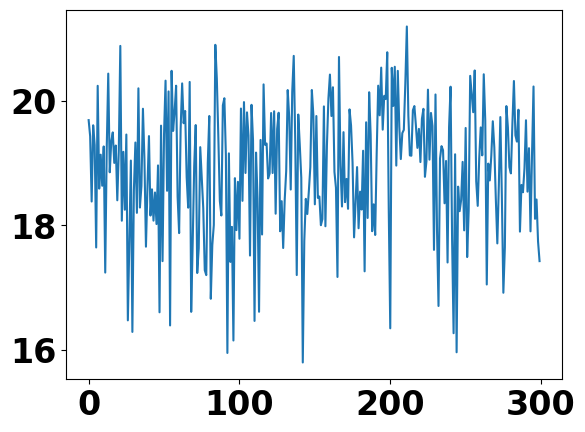

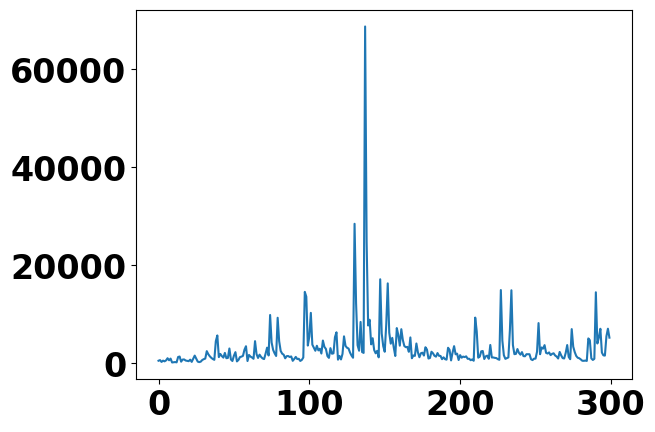

Env:1|Iteration:300|loss:2475.98|reward:18.62|action:tensor([3, 3, 2, 1])|rscore:0.5342616641657512
Env:1|Iteration:301|loss:1847.90|reward:19.34|action:tensor([3, 2, 0, 0])|rscore:0.5178541764157256
Env:1|Iteration:302|loss:2177.17|reward:19.19|action:tensor([0, 0, 1, 1])|rscore:0.5183339851678813
Env:1|Iteration:303|loss:2088.62|reward:20.81|action:tensor([0, 1, 2, 3])|rscore:0.7387814189166462
Env:1|Iteration:304|loss:1397.91|reward:18.62|action:tensor([3, 2, 0, 0])|rscore:0.47477895066156217
Env:1|Iteration:305|loss:983.09|reward:18.35|action:tensor([3, 2, 0, 0])|rscore:0.6087655267565779
Env:1|Iteration:306|loss:1246.05|reward:18.02|action:tensor([3, 2, 0, 0])|rscore:0.45120408436563364
Env:1|Iteration:307|loss:996.33|reward:18.82|action:tensor([0, 0, 1, 1])|rscore:0.5361990378639434
Env:1|Iteration:308|loss:4216.55|reward:18.76|action:tensor([0, 0, 1, 1])|rscore:0.46433465937272755
Env:1|Iteration:309|loss:1914.42|reward:19.31|action:tensor([1, 0, 2, 2])|rscore:0.5115615751783673

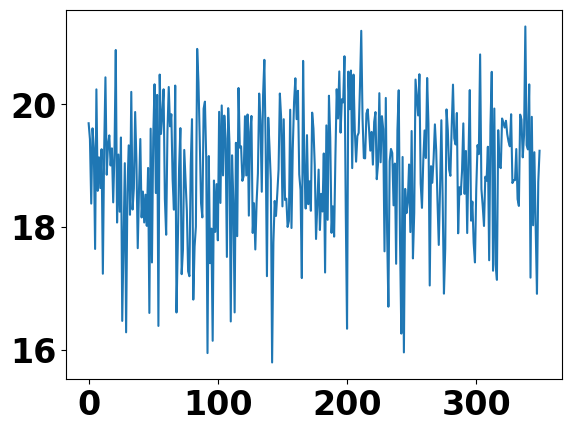

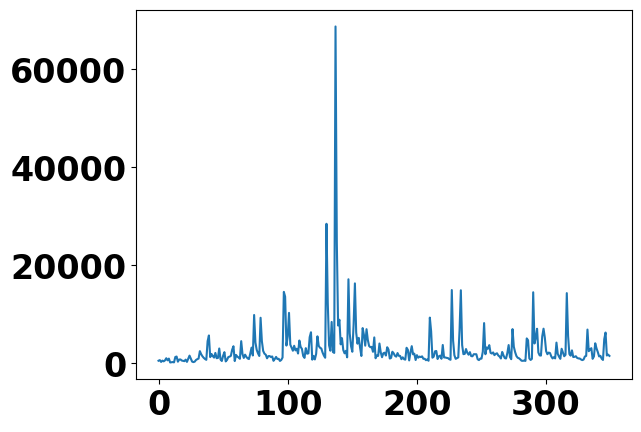

Env:1|Iteration:350|loss:3945.76|reward:21.02|action:tensor([0, 1, 2, 3])|rscore:0.792253028785904
Env:1|Iteration:351|loss:2095.39|reward:19.40|action:tensor([3, 2, 3, 0])|rscore:0.5608124773871785
Env:1|Iteration:352|loss:4637.82|reward:19.15|action:tensor([3, 0, 0, 0])|rscore:0.5836189937955043
Env:1|Iteration:353|loss:2256.70|reward:19.47|action:tensor([0, 2, 3, 0])|rscore:0.5509326668612035
Env:1|Iteration:354|loss:2164.67|reward:20.11|action:tensor([1, 0, 2, 3])|rscore:0.6882094358504074
Env:1|Iteration:355|loss:2511.37|reward:18.94|action:tensor([3, 2, 0, 0])|rscore:0.4606602224693382
Env:1|Iteration:356|loss:3121.81|reward:18.84|action:tensor([1, 1, 2, 1])|rscore:0.5710188993221958
Env:1|Iteration:357|loss:1749.02|reward:18.85|action:tensor([0, 0, 3, 0])|rscore:0.5715377417420848
Env:1|Iteration:358|loss:1773.21|reward:17.59|action:tensor([1, 3, 0, 1])|rscore:0.47998002220054237
Env:1|Iteration:359|loss:831.63|reward:17.06|action:tensor([1, 3, 1, 3])|rscore:0.26057954305623326


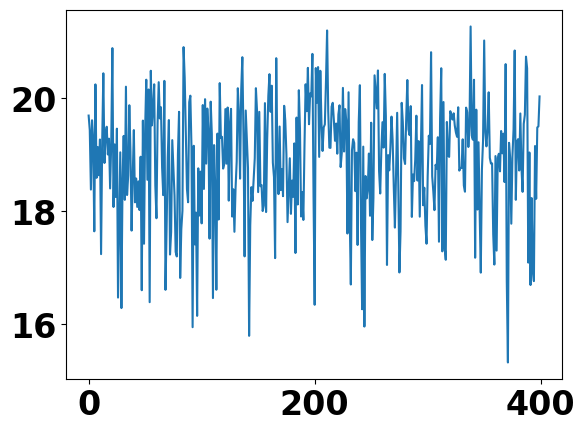

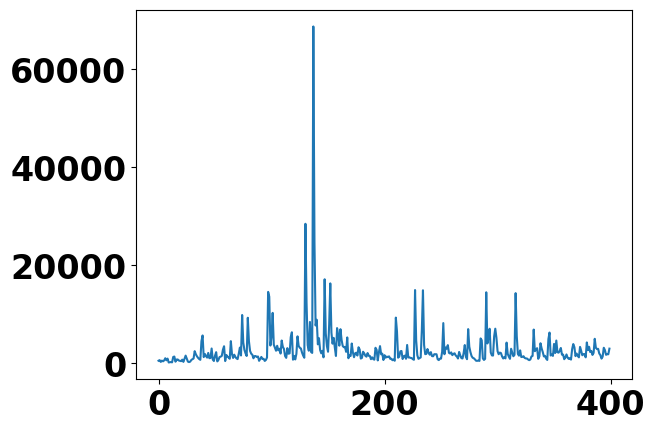

Env:1|Iteration:400|loss:2325.22|reward:19.38|action:tensor([3, 3, 0, 3])|rscore:0.578835277089746
Env:1|Iteration:401|loss:1784.94|reward:18.99|action:tensor([0, 1, 2, 3])|rscore:0.598616179862657
Env:1|Iteration:402|loss:1595.45|reward:19.03|action:tensor([3, 1, 0, 1])|rscore:0.5490293800074886
Env:1|Iteration:403|loss:1453.34|reward:19.55|action:tensor([0, 0, 3, 0])|rscore:0.6281051235664444
Env:1|Iteration:404|loss:982.76|reward:19.44|action:tensor([1, 0, 2, 2])|rscore:0.5878070253246697
Env:1|Iteration:405|loss:1145.23|reward:18.74|action:tensor([1, 0, 2, 2])|rscore:0.6260325166583509
Env:1|Iteration:406|loss:1788.95|reward:20.39|action:tensor([0, 0, 2, 1])|rscore:0.6145674716681098
Env:1|Iteration:407|loss:1401.23|reward:16.99|action:tensor([2, 3, 3, 2])|rscore:0.2667160435440348
Env:1|Iteration:408|loss:2145.64|reward:19.93|action:tensor([1, 0, 0, 0])|rscore:0.5288914838909751
Env:1|Iteration:409|loss:1868.95|reward:18.09|action:tensor([0, 0, 2, 1])|rscore:0.47061925178968056
En

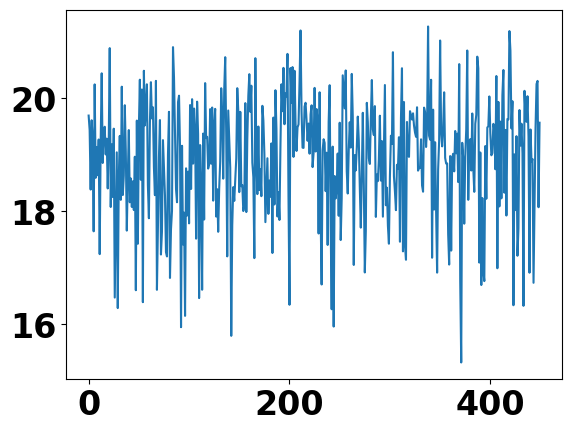

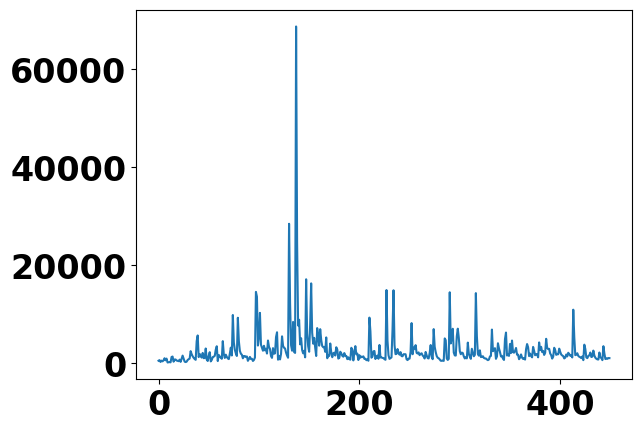

Env:1|Iteration:450|loss:1019.39|reward:20.53|action:tensor([3, 2, 0, 0])|rscore:0.7962107993949827
Env:1|Iteration:451|loss:637.10|reward:18.57|action:tensor([0, 0, 2, 2])|rscore:0.6059598901027404
Env:1|Iteration:452|loss:698.51|reward:17.72|action:tensor([2, 3, 0, 3])|rscore:0.2975099669047202
Env:1|Iteration:453|loss:3703.42|reward:18.91|action:tensor([1, 2, 1, 1])|rscore:0.5770976128578778
Env:1|Iteration:454|loss:2576.03|reward:14.92|action:tensor([0, 3, 1, 3])|rscore:0.21523527366132456
Env:1|Iteration:455|loss:1176.40|reward:18.87|action:tensor([0, 3, 2, 3])|rscore:0.5100529598033113
Env:1|Iteration:456|loss:934.71|reward:18.18|action:tensor([0, 3, 1, 3])|rscore:0.519621507405037
Env:1|Iteration:457|loss:781.32|reward:20.61|action:tensor([1, 0, 2, 0])|rscore:0.6533308870160661
Env:1|Iteration:458|loss:693.78|reward:20.35|action:tensor([3, 3, 0, 3])|rscore:0.6743340662000139
Env:1|Iteration:459|loss:703.07|reward:21.04|action:tensor([3, 1, 3, 1])|rscore:0.7489571650390927
Env:1|

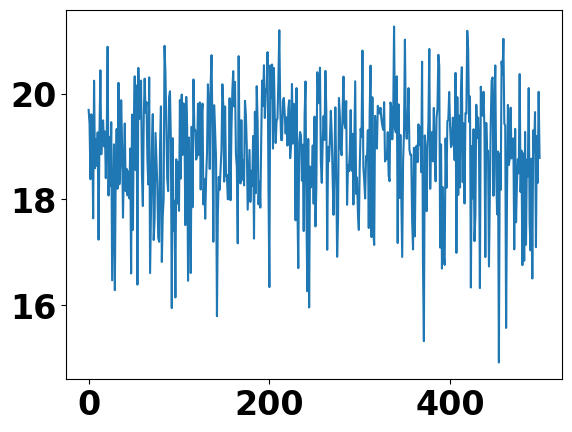

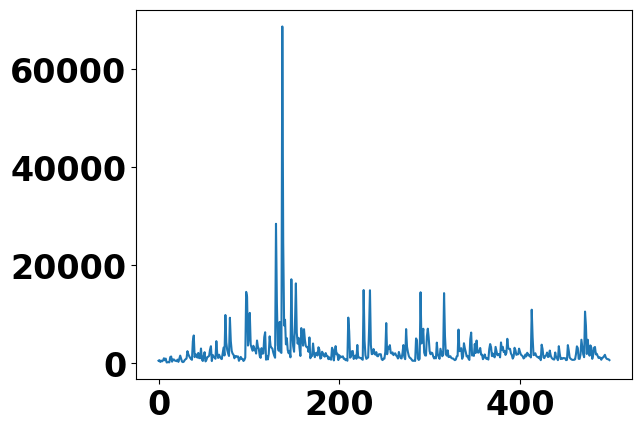

Env:1|Iteration:500|loss:1065.97|reward:19.79|action:tensor([0, 3, 1, 0])|rscore:0.6210007487366651
Env:1|Iteration:501|loss:1559.53|reward:17.57|action:tensor([2, 3, 0, 3])|rscore:0.33226142436569595
Env:1|Iteration:502|loss:2187.60|reward:18.77|action:tensor([3, 0, 1, 0])|rscore:0.5683574299439099
Env:1|Iteration:503|loss:1448.16|reward:19.41|action:tensor([2, 1, 1, 2])|rscore:0.6021241652688023
Env:1|Iteration:504|loss:944.41|reward:17.77|action:tensor([3, 3, 0, 1])|rscore:0.41942905772534556
Env:1|Iteration:505|loss:1009.01|reward:20.01|action:tensor([3, 0, 0, 1])|rscore:0.6313791645727518
Env:1|Iteration:506|loss:1195.92|reward:18.77|action:tensor([3, 0, 0, 2])|rscore:0.5717956630475307
Env:1|Iteration:507|loss:1584.25|reward:19.84|action:tensor([2, 2, 3, 1])|rscore:0.5928357804483824
Env:1|Iteration:508|loss:2418.79|reward:18.55|action:tensor([0, 0, 3, 0])|rscore:0.40720845154846963
Env:1|Iteration:509|loss:2563.29|reward:18.07|action:tensor([2, 3, 1, 0])|rscore:0.271206710164432

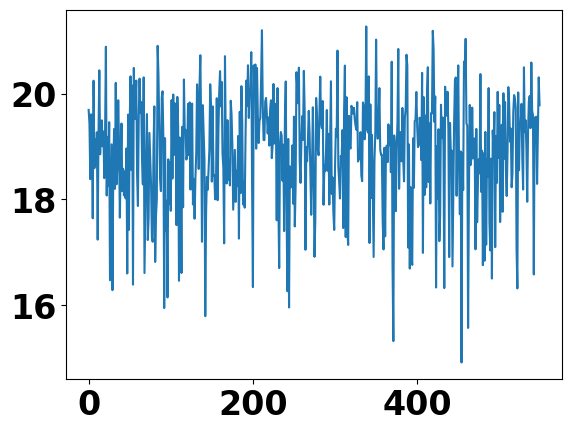

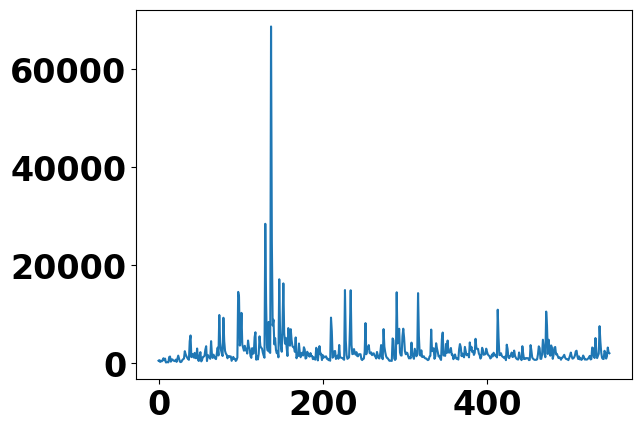

Env:1|Iteration:550|loss:1008.04|reward:18.77|action:tensor([3, 3, 1, 3])|rscore:0.5339596099728652
Env:1|Iteration:551|loss:987.81|reward:18.59|action:tensor([0, 0, 2, 0])|rscore:0.4911275546858684
Env:1|Iteration:552|loss:1064.29|reward:16.84|action:tensor([1, 0, 1, 3])|rscore:0.28217407273337486
Env:1|Iteration:553|loss:1208.56|reward:16.83|action:tensor([3, 0, 3, 3])|rscore:0.44364870565952585
Env:1|Iteration:554|loss:2459.70|reward:20.43|action:tensor([0, 1, 2, 3])|rscore:0.769319190303439
Env:1|Iteration:555|loss:2974.06|reward:18.81|action:tensor([0, 1, 2, 3])|rscore:0.6186148173099222
Env:1|Iteration:556|loss:2453.28|reward:20.11|action:tensor([1, 1, 3, 2])|rscore:0.6411036306021115
Env:1|Iteration:557|loss:1450.72|reward:16.16|action:tensor([0, 3, 2, 1])|rscore:0.23021459844928213
Env:1|Iteration:558|loss:1761.42|reward:19.66|action:tensor([1, 3, 0, 3])|rscore:0.666394626480405
Env:1|Iteration:559|loss:3369.15|reward:18.94|action:tensor([1, 3, 0, 3])|rscore:0.5165581453184067


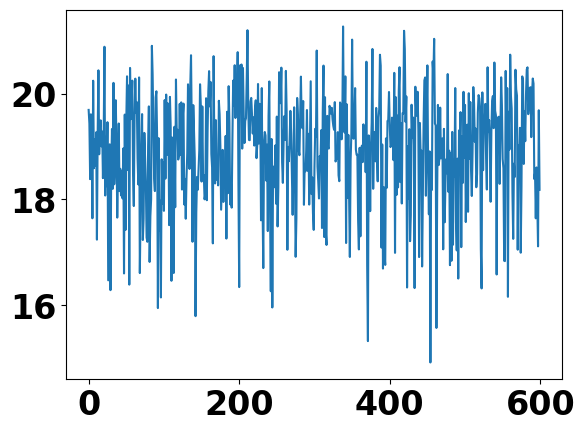

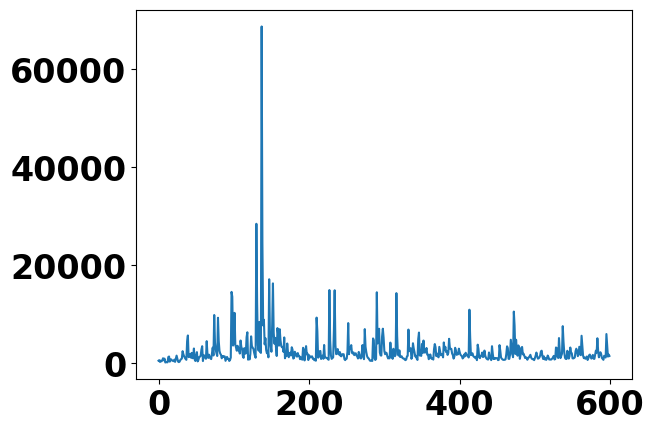

Env:1|Iteration:600|loss:828.40|reward:17.32|action:tensor([2, 0, 3, 3])|rscore:0.27896733222724235
Env:1|Iteration:601|loss:1443.40|reward:19.57|action:tensor([2, 2, 0, 3])|rscore:0.5881827873984438
Env:1|Iteration:602|loss:5510.88|reward:19.26|action:tensor([0, 2, 2, 2])|rscore:0.6191535976054932
Env:1|Iteration:603|loss:3414.46|reward:19.10|action:tensor([2, 2, 0, 3])|rscore:0.5640665335950397
Env:1|Iteration:604|loss:946.39|reward:19.87|action:tensor([1, 1, 2, 3])|rscore:0.6451269157678353
Env:1|Iteration:605|loss:1165.53|reward:18.01|action:tensor([3, 0, 1, 2])|rscore:0.45022262842580285
Env:1|Iteration:606|loss:1321.69|reward:18.48|action:tensor([1, 0, 1, 1])|rscore:0.5198656037305542
Env:1|Iteration:607|loss:1776.65|reward:19.02|action:tensor([1, 0, 1, 1])|rscore:0.7096206656842574
Env:1|Iteration:608|loss:1158.69|reward:19.97|action:tensor([2, 0, 1, 2])|rscore:0.5639316015915025
Env:1|Iteration:609|loss:1779.91|reward:19.64|action:tensor([0, 1, 0, 1])|rscore:0.6000329089502784


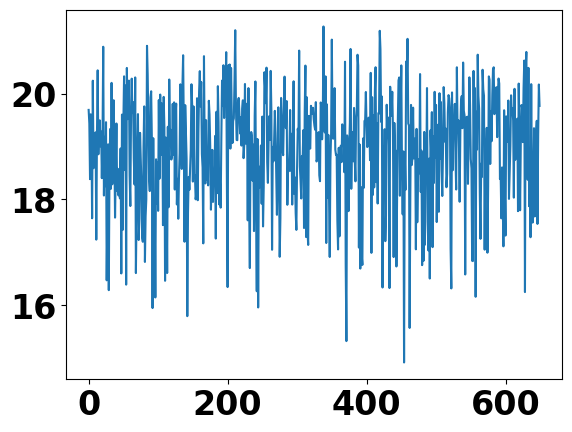

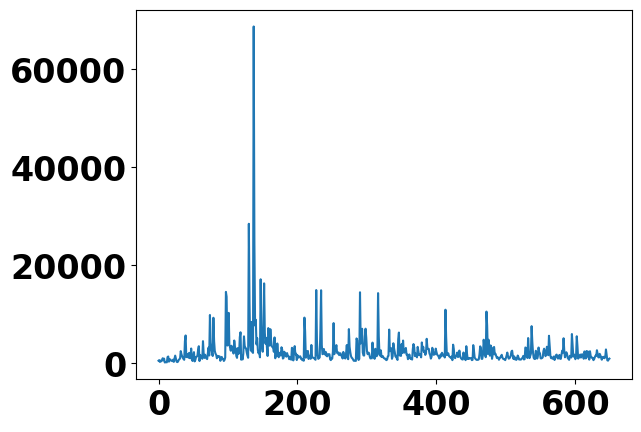

Env:1|Iteration:650|loss:1262.09|reward:18.70|action:tensor([0, 0, 3, 0])|rscore:0.6019601263132146
Env:1|Iteration:651|loss:1035.17|reward:19.08|action:tensor([1, 0, 2, 3])|rscore:0.5374331490601586
Env:1|Iteration:652|loss:903.21|reward:21.06|action:tensor([0, 2, 3, 0])|rscore:0.7294469200560048
Env:1|Iteration:653|loss:1544.92|reward:21.02|action:tensor([0, 2, 2, 0])|rscore:0.7647258358765638
Env:1|Iteration:654|loss:757.37|reward:18.96|action:tensor([3, 2, 1, 1])|rscore:0.6267073203700878
Env:1|Iteration:655|loss:995.78|reward:20.21|action:tensor([0, 1, 0, 1])|rscore:0.6564268826786549
Env:1|Iteration:656|loss:1253.34|reward:19.75|action:tensor([0, 1, 2, 2])|rscore:0.5410211692517137
Env:1|Iteration:657|loss:947.87|reward:19.02|action:tensor([1, 2, 0, 1])|rscore:0.6755771692623822
Env:1|Iteration:658|loss:789.83|reward:19.38|action:tensor([2, 1, 3, 3])|rscore:0.5660621246009422
Env:1|Iteration:659|loss:1949.45|reward:19.34|action:tensor([3, 0, 0, 3])|rscore:0.6381209960282583
Env:1

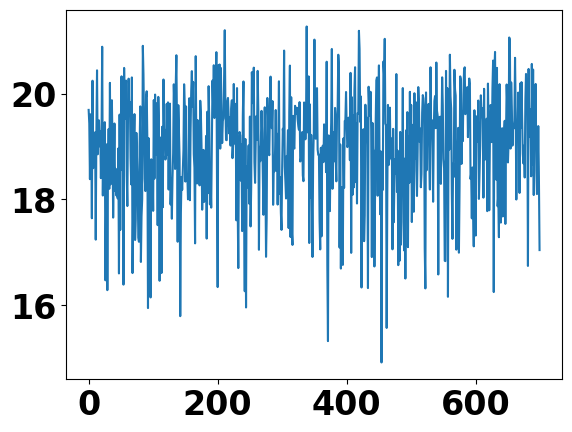

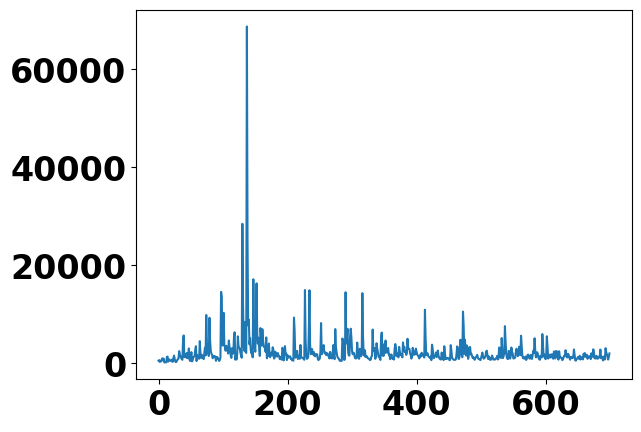

Env:1|Iteration:700|loss:2159.14|reward:20.19|action:tensor([0, 2, 3, 0])|rscore:0.6956025630187808
Env:1|Iteration:701|loss:1406.76|reward:17.79|action:tensor([3, 1, 1, 1])|rscore:0.5463372710749343
Env:1|Iteration:702|loss:800.47|reward:17.72|action:tensor([1, 2, 1, 1])|rscore:0.31755372918619684
Env:1|Iteration:703|loss:1743.48|reward:19.02|action:tensor([1, 2, 1, 1])|rscore:0.5480698546345423


In [ ]:
import pdb
# Defining hyperparams
niterations = 1000
max_inner_iter = 1000
max_test_iter = 1000
outerstepsize = 1
# random_seeds = [0,5,3,6,9,14,16,25,22,29]
# random_seeds = [35, 40, 45]
random_seeds = [1,2,3,4,5]
k = 0
epsilon = 0.9
results_dict = {"loss": None,
               "reward": None}
# pbar = tqdm(range(niterations))
# best = 0
gamma = 0.98
set_seed(15)
r_history, loss_history = [], []
for k in random_seeds:
    lr = 0.01
    inter_file_name = 'AP4UE10Act5_Individual_avg.pkl'
# enable cuda in training
    cuda_flag = True

    # initialize learner
    avg_controller = DRQN_Agent(input_shape=24, n_actions=256) #n_actions = 6 * 5, input_shape = 11
    avg_controller.save('models/' + inter_file_name)
    avg_controller.cuda()
    avg_learner = QLearner(avg_controller,device="cuda",batch_size=32,num_feats=64, est_type = "average")
    if cuda_flag:
        avg_learner.cuda()

    # initialize test learner
    test_controller = DRQN_Agent(input_shape=24, n_actions=256) #n_actions = 6 * 5, input_shape = 11
    test_controller.load('models/' + inter_file_name)
    test_controller.cuda()
#     test_controller.init_hidden(batch_size=1)

    avg_learner.set_sgd(lr)
    pbar = tqdm(range(niterations))
    env = envs[k]
    best = 0
    r_history, loss_history = [], []
    for iteration in pbar:
        env.reset()
        inner_step = 0
        if (iteration + 1) % 100 == 0:
            lr = lr/2
            lr = max(lr, 1e-4)
            avg_learner.set_sgd(lr)
        losses = []
    
        for inner_iter in range(max_inner_iter):
            total_step = max_inner_iter * iteration + inner_iter
#         inner_step += 1
#             obs = [5
# #         breakpoint()
#             for j in range(env.n_enbs):
#                 obs.append(env.get_agent_obs(j))
#             obs = torch.stack(obs, dim=0)
#             obs = torch.flatten(obs)
            obs = env.struct_obv()
#         breakpoint()
            cur_obs = obs.reshape(1,24).cuda()
#             avg_controller.init_hidden(1)
            action,q = avg_controller.get_action(cur_obs, 1 * (1-iteration/niterations))
#             if random.random() < epsilon:
#                 action = np.random.randint(255)
#             pdb.set_trace()
            act = decode_act(action,4,4)
            s_t1,r,_ = env.step(act)
            s_t1 = torch.flatten(s_t1)
#             avg_controller.init_hidden(512)
            loss, grad = avg_learner.train(obs.numpy(), action,
                                   r.item(), s_t1.numpy(), total_step)
            if loss is not None:
                losses.append(loss.item())
        
        avg_learner._update_targets()
    # Save the results
        if losses != []:
            loss_history.append(np.mean(losses))
    # save and update the test controller
        avg_controller.save('models/' + inter_file_name)
        test_controller.load('models/' + inter_file_name)
        env.reset()
        reward = 0
#         epsilon -= 1/(niterations + 1)
        for test_iter in range(max_test_iter):
#             obs = []
#             for j in range(env.n_enbs):
#                 obs.append(env.get_agent_obs(j))
# #         breakpoint()
#             obs = torch.stack(obs, dim=0)
#             obs = torch.flatten(obs)
            obs = env.struct_obv()
            action,_ = test_controller.get_action(
                torch.reshape(obs,(1,24)).cuda(), 0.0)
#             action = 0
#             action = 0
            act = decode_act(action,4,4)
#             act = np.array([[0,0,0,0]])
            s_t1,r,_ = env.step(act)
            reward += r
        r_history.append(reward.item()/max_test_iter)
        pbar.set_description(f"Env:{k}|Iteration:{iteration}|loss:{np.mean(losses):.2f}|reward:{np.mean(r_history):.2f}|action:{act}")
        print(f"Env:{k}|Iteration:{iteration}|loss:{np.mean(losses):.2f}|reward:{reward.item()/max_test_iter:.2f}|action:{act}|rscore:{env.get_Rsum()/24 + env.get_R5per()*3}")
        if r.item() > best and iteration > 10:
            best = r.item()
            print(f"Current best {best:.2f} at iteration {iteration}! Saving.... ")
            test_controller.save(f"./models/drqn_best_centralized_env{k}.pkl")
        if (iteration + 1) % 50 == 0:
            plt.plot(r_history)
            plt.show()

            plt.plot(loss_history)
            plt.show()
            results_dict["loss"] = loss_history
            results_dict["reward"] = r_history
            with open(f"./results/env_{k}_centralized_results_{niterations}_avg.pkl", "wb") as file:
                pickle.dump(results_dict, file)

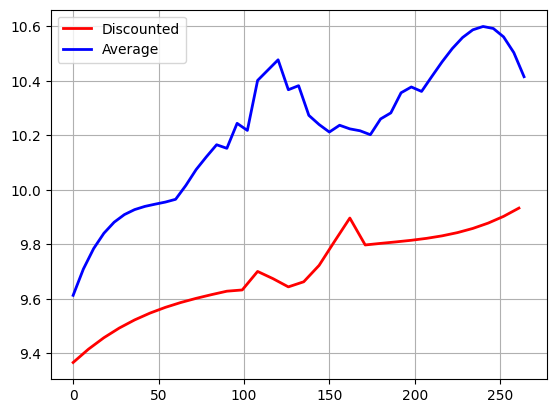

In [44]:
from scipy.signal import savgol_filter
with open("./results/env_10_centralized_results_avg.pkl", "rb") as file:
            avg_result = pickle.load(file)
with open("./results/env_10_centralized_results_dist.pkl", "rb") as file:
            dist_result = pickle.load(file)
avg_history = avg_result["reward"]
dist_history = dist_result["reward"]
plt.plot(list(range(0,270,9)),savgol_filter(dist_history[20:50], 21, 3) , lw = 2, color = "red", label = "Discounted")
plt.plot(list(range(0,270,6)),savgol_filter(avg_history[0:45], 21, 3) , lw = 2, color = "blue", label = "Average")

plt.grid()
plt.legend()

In [ ]:
dist_

### Draw results

In [16]:
with open("./results/env_0_results.pkl", "rb") as file:
            result = pickle.load(file)

In [2]:
import torch
import numpy as np
import torch.nn as nn
import pickle
import os 
import sys
import matplotlib.pyplot as plt

In [3]:
from glob import glob
dirs = glob("./results/*_results*_avg.pkl")
discounted_dirs = glob("./results/*_results*_dist.pkl")

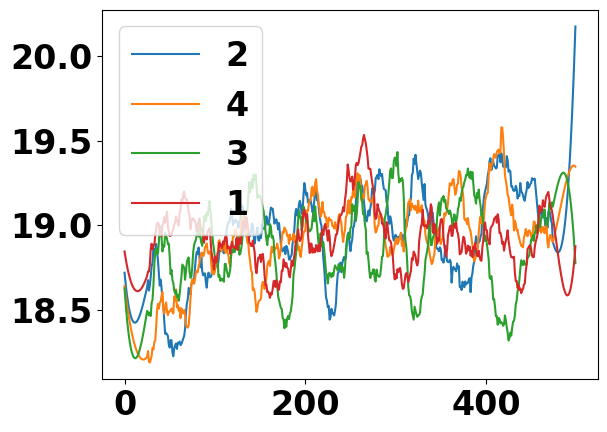

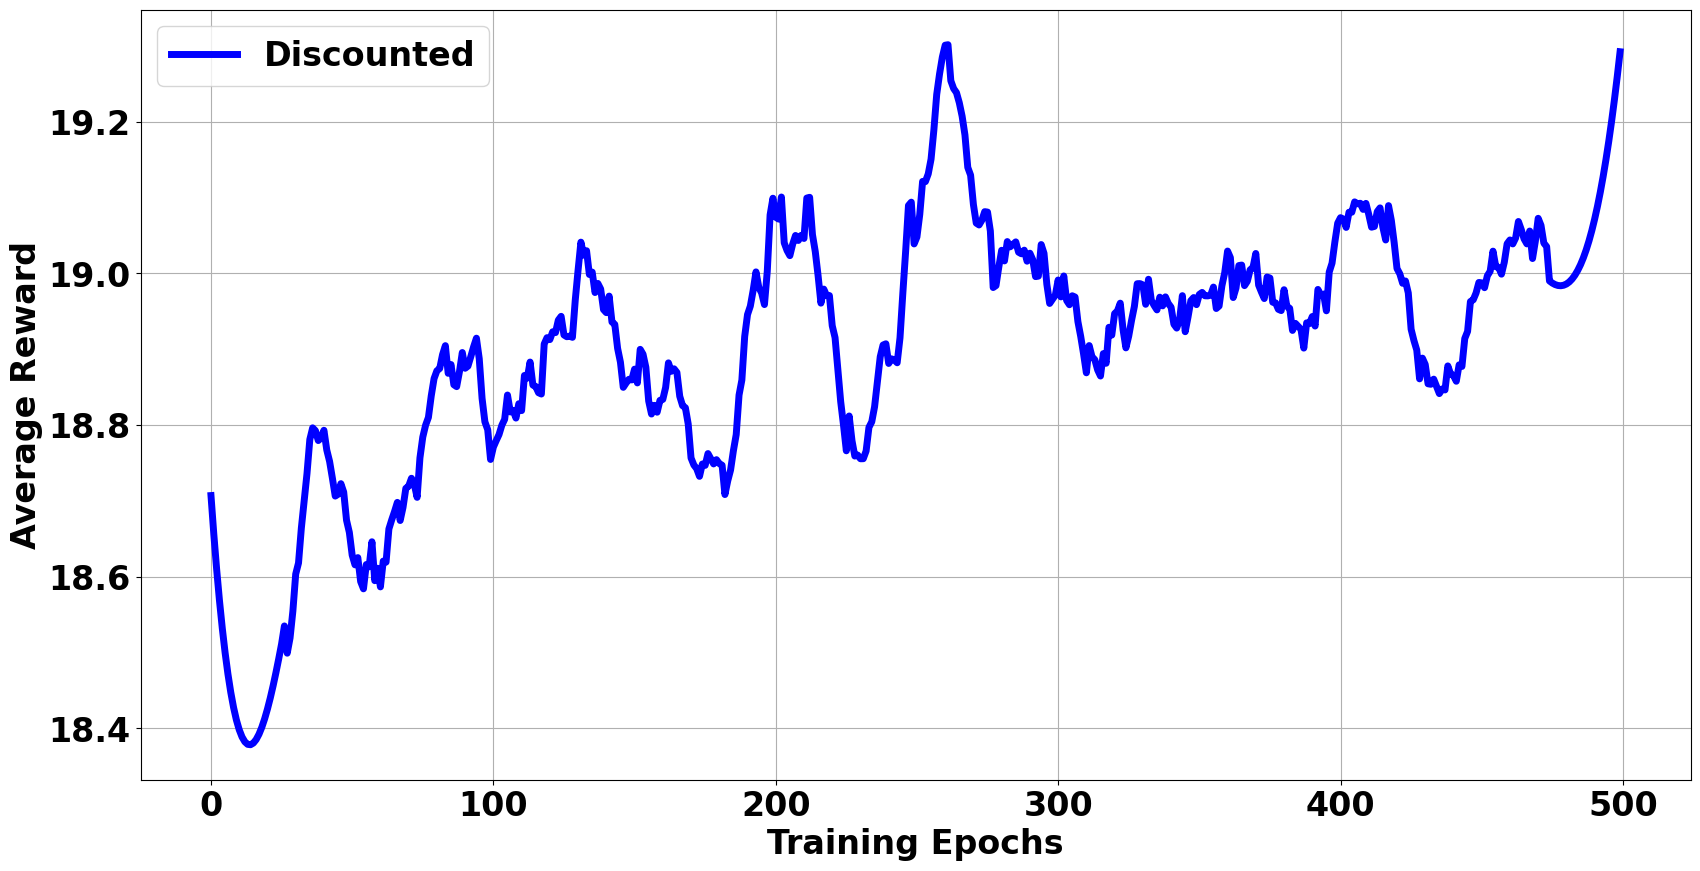

In [13]:
import json
import matplotlib
import pdb
from scipy.signal import savgol_filter

figure_map= {
    "MARL":["b", "-"],
    "Centralized_RL":["r","-."],
    "Heuristic_baseline":["g",":"]
    
}

font = {'weight' : 'bold',
        'size'   : 24}

results = {}

for i,d in enumerate(dirs):
#     breakpoint()
    d = dirs[i]
    label = dirs[i].split("_")[-1]
    env_num = dirs[i].split("_")[1]
    
    
    with open(d, "rb") as f:
#         breakpoint()
        res = pickle.load(f)
        r = res["reward"]
        if len(r) != 1000:
            continue
        if label not in results and rounds == "500":
            results[label] = np.zeros((len(r),))
            r = np.array(r)
            plt.plot(savgol_filter(r, 51, 3), label = env_num)
            results[label] += np.array(r)
        elif rounds == "500":
            r = np.array(r)
            plt.plot(savgol_filter(r, 51, 3), label = env_num)
            results[label] += np.array(r)
            
for i,d in enumerate(discounted_dirs):
#     breakpoint()
    d = discounted_dirs[i]
    label = discounted_dirs[i].split("_")[-1]
    rounds = discounted_dirs[i].split("_")[-2]
    env_num = discounted_dirs[i].split("_")[1]
    
    with open(d, "rb") as f:
#         breakpoint()
        res = pickle.load(f)
        r = res["reward"]
        if len(r) != 500:
            continue
        if label not in results and rounds == "500":
            results[label] = np.zeros((len(r),))
            r = np.array(r)
            plt.plot(savgol_filter(r, 51, 3), label = env_num)
            results[label] += np.array(r)
        elif rounds == "500":
            r = np.array(r)
            plt.plot(savgol_filter(r, 51, 3), label = env_num)
            results[label] += np.array(r)
plt.legend()
plt.figure(figsize = (20,10))
# if label == "centralized":
#     label_n = "Centralized_RL"
# plt.plot(savgol_filter(results["avg.pkl"], 21, 3)/(len(dirs)-1),c = "red",lw=5 ,ls="-", label = "Average")
plt.plot(savgol_filter(results["dist.pkl"], 51, 3)/4,c = "blue",lw=5 ,ls="-", label = "Discounted")
plt.xlabel("Training Epochs", fontsize=24, weight="bold")
plt.ylabel("Average Reward", fontsize=24, weight="bold")
matplotlib.rc('font', **font)
plt.grid()
plt.legend()



In [7]:
label

'dist.pkl'

In [31]:
discounted_dirs

{'avg.pkl': array([72.76444824, 73.45820117, 71.87247168, 70.49756445, 70.63403418,
        68.6964707 , 71.83890918, 71.02915625, 70.07533887, 72.09348926,
        70.45494629, 70.87125195, 71.51434082, 70.95227734, 69.43533594,
        72.12023145, 71.690125  , 72.37347949, 65.45757422, 73.61198926,
        74.77852148, 75.40505762, 71.06977051, 68.35014063, 70.52982617,
        73.54578809, 70.54400391, 69.61815625, 70.38443164, 71.92041602,
        71.1116543 , 68.55984863, 73.0707627 , 73.1720293 , 69.0735166 ,
        70.3371377 , 71.11877539, 72.6862002 , 71.94347461, 66.41691504,
        73.00295215, 73.03091211, 72.96919141, 73.1762041 , 71.21913867,
        71.45881445, 71.57537305, 71.85431348, 73.71394336, 71.67754395,
        70.49353027, 70.19437695, 70.43468359, 72.5342168 , 70.83730078,
        73.19099414, 70.47850293, 73.10580078, 72.96875781, 69.34169629,
        74.12401172, 71.8471748 , 69.5685166 , 70.6730332 , 72.60814746,
        72.23181836, 71.35037012, 71.789